In [ ]:
# importing all the required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [ ]:
# load the dataset
data_variants = pd.read_csv('/content/drive/MyDrive/Datasets/training_variants')
data_text =pd.read_csv("/content/drive/MyDrive/Datasets/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

## DATA EXPLORATION

#### Explore data_variants

In [ ]:
# 
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [ ]:
# Checking dimensions of data
print (f"Dimensions of data_variants are: {data_variants.shape[0]} rows and {data_variants.shape[1]} columns.")
# Listing the column names
print (f"Column names are: {data_variants.columns}")

Dimensions of data_variants are: 3321 rows and 4 columns.
Column names are: Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


In [ ]:
# No missing values
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


#### Exploring data_text

In [ ]:
data_text.head(3)
# id is common between both the datasets

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [ ]:
data_text.info()
# There are some missing values in TEXT column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


#### Conclusion from Data exploration

Datasets looks like this:
* data_variants (ID, Gene, Variations, Class)
* data_text(ID, text)

## TEXT PREPROCESSING

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
len(stop_words)

179

In [ ]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values
    if type(total_text) is not int:
        string = ""
        # replace special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # lowercase the whole text
        total_text = total_text.lower()
        
        # Removing the stopwords
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

# apply the preprocessing function on each of the rows
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [ ]:
# text column has been pre-processed as desired
data_text

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
...,...,...
3316,3316,introduction myelodysplastic syndromes mds het...
3317,3317,introduction myelodysplastic syndromes mds het...
3318,3318,runt related transcription factor 1 gene runx1...
3319,3319,runx1 aml1 gene frequent target chromosomal tr...


In [ ]:
# merge the two datasets on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head(3)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...


## IMPUTING MISSING VALUES

In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
# imputing the missing TEXT by Gene + Variation
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
print (result.loc [1109,'TEXT'])
print (result.loc [1277,'TEXT'])
print (result.loc [1407,'TEXT'])
print (result.loc [1639,'TEXT'])
print (result.loc [2755,'TEXT'])

FANCA S1088F
ARID5B Truncating Mutations
FGFR3 K508M
FLT1 Amplification
BRAF G596C


## TRAIN-DEV-TEST SPLIT

In [ ]:
# replacing ' ' by '_' in Gene and Varaition columns
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [ ]:
# Doing a 3-way train-dev-test split
# It must be ensured that the class-distribution across data is equal
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


## RANDOM MODEL
This model will predict classes randomly.

It will help us compare what can be considered as a good value of log-loss.

#### Building random model and create a baseline for log-loss

In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [ ]:
# For dev set
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.4245857133580087


In [ ]:
# For test set
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.493288720412716


In [ ]:
# The predictions made by this model on test set
predicted_y =np.argmax(test_predicted_y, axis=1)

print (predicted_y)

[3 8 0 0 5 0 5 5 2 3 1 5 8 3 8 6 4 0 3 4 0 0 5 5 8 4 4 7 3 0 7 7 7 3 3 0 5
 5 6 5 4 5 6 7 1 4 2 4 4 5 1 4 6 7 7 0 1 0 8 7 7 8 4 5 3 7 2 7 8 0 4 8 3 6
 4 1 3 0 4 3 5 0 3 4 1 7 2 1 5 2 5 1 0 4 7 5 4 0 3 5 4 1 1 6 1 4 2 6 7 0 1
 3 0 3 4 8 5 1 5 7 6 8 6 3 4 8 3 3 6 4 2 7 4 0 8 6 7 8 8 1 6 5 3 5 8 7 2 1
 1 3 8 7 2 5 6 1 8 4 7 3 6 3 2 6 0 4 2 5 6 1 3 6 6 4 4 1 8 6 8 0 5 4 8 8 1
 7 3 6 5 4 3 3 7 3 3 3 0 4 8 0 2 2 4 3 4 7 6 6 6 2 6 6 0 7 1 7 6 5 7 7 6 6
 7 2 6 0 3 2 0 1 5 3 0 7 3 6 1 7 2 0 2 2 6 7 5 3 2 6 0 3 3 1 5 1 3 1 8 7 2
 2 7 7 2 2 2 3 3 7 8 1 6 1 4 1 7 7 6 7 4 2 8 7 2 2 2 0 8 2 0 3 3 8 3 6 2 6
 8 4 8 2 0 4 1 5 2 5 4 8 6 6 1 1 5 8 2 1 1 3 7 6 2 0 8 7 8 8 4 6 8 6 4 3 8
 3 4 2 6 7 1 6 5 6 5 4 3 3 3 8 3 6 1 2 7 6 5 4 0 2 0 4 0 7 2 2 6 0 7 7 5 4
 0 1 5 5 1 2 5 2 8 0 7 2 1 3 0 6 1 3 6 2 4 4 8 6 6 5 6 6 4 1 8 2 5 8 0 8 0
 0 1 7 6 8 1 7 2 3 7 3 2 2 2 5 8 7 6 2 4 0 3 2 2 7 8 3 0 3 6 2 5 1 2 7 2 4
 6 1 4 3 8 8 1 7 5 5 5 3 2 2 4 2 7 3 5 6 2 2 4 7 5 6 4 2 7 6 2 3 0 1 7 4 2
 7 7 2 4 2 3 0 4 3 6 0 8 

In [ ]:
# to get labels from 1-9 instead of 0-8
predicted_y = predicted_y +1

#### Evaluating random model on other parameters

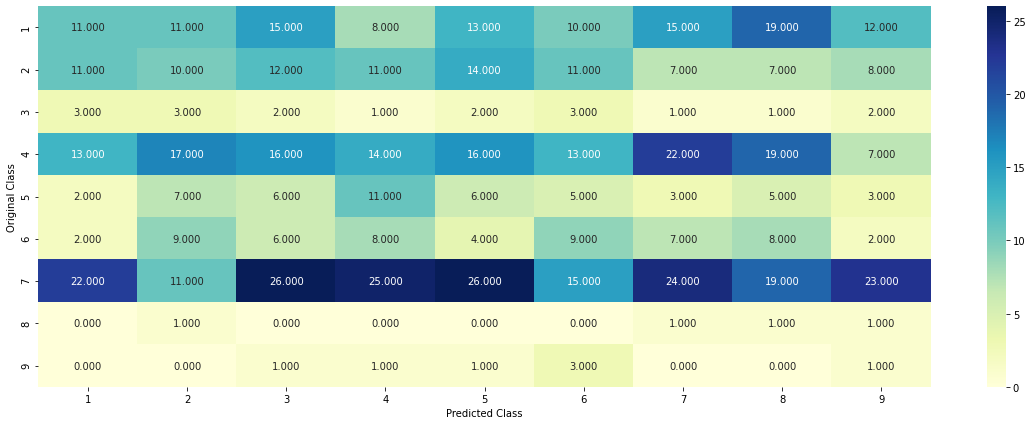

In [ ]:
C = confusion_matrix(y_test, predicted_y)

labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## EVALUATE GENE COLUMN

In [ ]:
# Unique gene types in the Gene column
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 239
BRCA1     168
TP53      110
EGFR       99
PTEN       81
BRCA2      74
KIT        62
BRAF       55
ALK        46
ERBB2      44
PIK3CA     39
Name: Gene, dtype: int64


In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
train_gene_feature_onehotCoding.shape

(2124, 238)

In [ ]:
# Defining the hyper-parameter alpha
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier just for the Gene column
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1768213339823443
For values of alpha =  0.0001 The log loss is: 1.1533747996421801
For values of alpha =  0.001 The log loss is: 1.2028841363429292
For values of alpha =  0.01 The log loss is: 1.3064310870332556
For values of alpha =  0.1 The log loss is: 1.417573131266999
For values of alpha =  1 The log loss is: 1.4632920856736298


In [ ]:
# Lets compute log-loss for the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0034445977426303
For values of best alpha =  0.0001 The cross validation log loss is: 1.1533747996421801
For values of best alpha =  0.0001 The test log loss is: 1.1999187572074457


CONCLUSION: As the log loss is almost half of the Random model, Gene column is very important for the prediction of Class

## EVALUATE VARIATION COLUMN

In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1921
Truncating_Mutations    61
Deletion                50
Amplification           47
Fusions                 20
Overexpression           6
E17K                     3
G12V                     3
Q61R                     3
R170W                    2
G67R                     2
Name: Variation, dtype: int64


In [ ]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1950)

In [ ]:
# define the hyper-parameter learning rate alpha
alpha = [10 ** x for x in range(-5, 1)]

# Using sgd classifier
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.701178392912394
For values of alpha =  0.0001 The log loss is: 1.695055063465732
For values of alpha =  0.001 The log loss is: 1.704525479830648
For values of alpha =  0.01 The log loss is: 1.7218158056900914
For values of alpha =  0.1 The log loss is: 1.7316645109969722
For values of alpha =  1 The log loss is: 1.733343578304198


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6999154186772815
For values of best alpha =  0.0001 The cross validation log loss is: 1.695055063465732
For values of best alpha =  0.0001 The test log loss is: 1.7228514182979697


## Evaluate Text Column

In [ ]:
# Create a dictionary of all the words
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52603


In [ ]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5127, 4: 3512, 5: 2684, 6: 2676, 9: 2116, 8: 1882, 7: 1780, 10: 1465, 12: 1347, 11: 1172, 13: 1069, 15: 954, 16: 908, 14: 831, 18: 701, 17: 632, 20: 623, 21: 485, 24: 477, 22: 467, 36: 436, 19: 431, 30: 386, 27: 386, 23: 365, 25: 360, 26: 356, 45: 335, 28: 314, 34: 311, 32: 309, 29: 260, 35: 256, 31: 250, 33: 248, 42: 241, 37: 234, 39: 220, 40: 209, 38: 191, 41: 187, 44: 184, 48: 178, 46: 178, 56: 167, 43: 165, 49: 161, 52: 151, 47: 150, 50: 147, 54: 143, 58: 139, 51: 138, 55: 137, 60: 130, 66: 128, 61: 121, 59: 117, 57: 115, 62: 114, 63: 111, 84: 110, 70: 110, 65: 108, 71: 106, 72: 102, 73: 99, 67: 96, 90: 95, 64: 95, 53: 95, 69: 91, 77: 90, 76: 89, 80: 87, 78: 82, 74: 81, 75: 78, 91: 76, 83: 76, 81: 75, 92: 74, 68: 74, 99: 69, 115: 64, 79: 64, 88: 63, 82: 63, 94: 60, 85: 59, 110: 58, 89: 57, 113: 56, 105: 56, 93: 56, 98: 55, 97: 54, 86: 54, 96: 53, 111: 52, 108: 51, 107: 51, 102: 51, 87: 51, 109: 50, 100: 50, 120: 49, 114: 49, 133: 48, 103: 48, 126: 47, 95: 47, 149: 46, 1

In [ ]:
# Building the model with only text column
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.3060373402186793
For values of alpha =  0.0001 The log loss is: 1.1925575171929166
For values of alpha =  0.001 The log loss is: 1.172433199866161
For values of alpha =  0.01 The log loss is: 1.2477403011912997
For values of alpha =  0.1 The log loss is: 1.4524824901091915
For values of alpha =  1 The log loss is: 1.6727393961580337


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6553040950048168
For values of best alpha =  0.001 The cross validation log loss is: 1.172433199866161
For values of best alpha =  0.001 The test log loss is: 1.212228765313643


## SOME IMPORTANT HELPER FUNCTION

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

## COMBING THE FEATURES

In [ ]:
# merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54791)
(number of data points * number of features) in test data =  (665, 54791)
(number of data points * number of features) in cross validation data = (532, 54791)


## NAIVE BAYES MODEL

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.2553889916210863
for alpha = 0.0001
Log Loss : 1.2520570791319758
for alpha = 0.001
Log Loss : 1.2560550754444018
for alpha = 0.1
Log Loss : 1.2407039220514076
for alpha = 1
Log Loss : 1.2343023300264666
for alpha = 10
Log Loss : 1.3520828972292858
for alpha = 100
Log Loss : 1.320533561318283
for alpha = 1000
Log Loss : 1.2910360320728147


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1 The train log loss is: 0.9134321771601829
For values of best alpha =  1 The cross validation log loss is: 1.2343023300264666
For values of best alpha =  1 The test log loss is: 1.2814566690782236


Log Loss : 1.2343023300264666
Number of missclassified point : 0.37593984962406013
-------------------- Confusion matrix --------------------


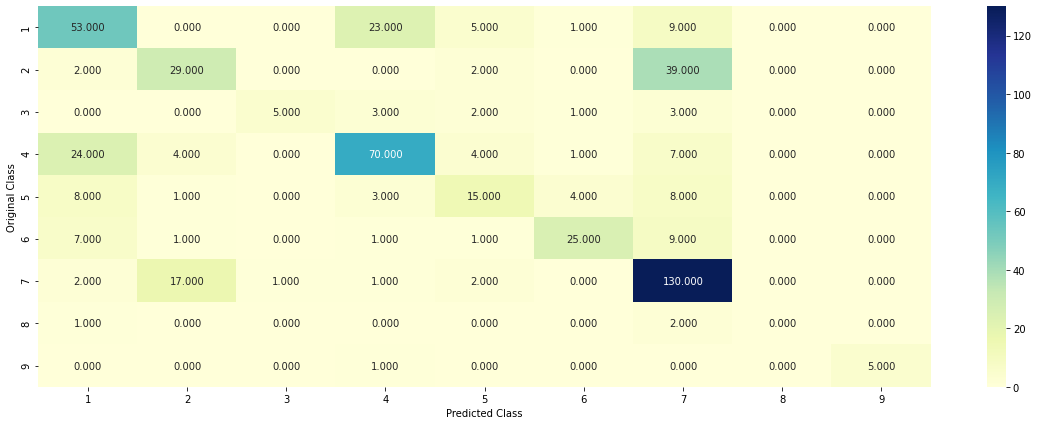

-------------------- Precision matrix (Columm Sum=1) --------------------


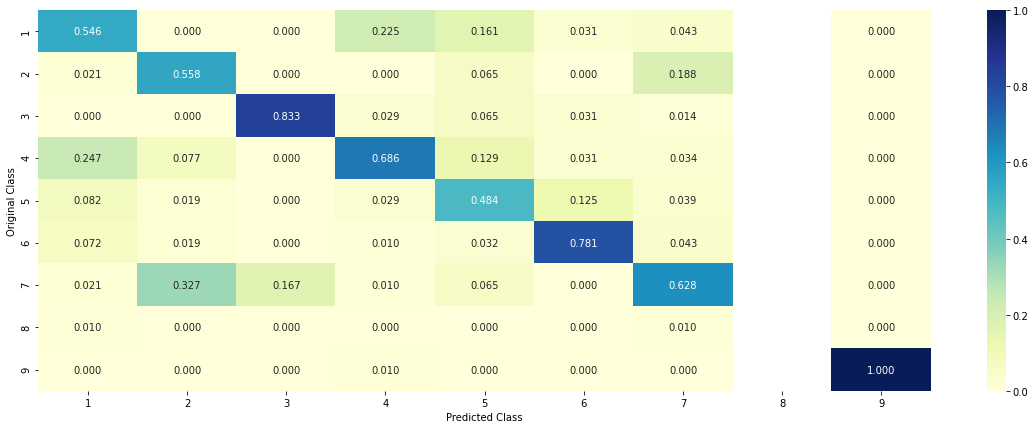

-------------------- Recall matrix (Row sum=1) --------------------


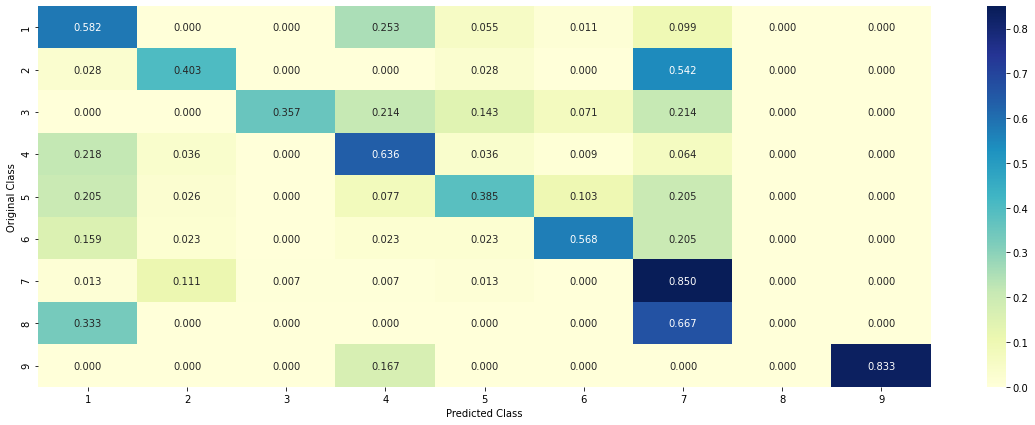

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

## LOGISTIC REGRESSION

#### WITH BALANCED CLASSES USING UPSAMPLING

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.321035536853496
for alpha = 1e-05
Log Loss : 1.297844648201165
for alpha = 0.0001
Log Loss : 1.147151687963455
for alpha = 0.001
Log Loss : 1.1212828831560477
for alpha = 0.01
Log Loss : 1.1567165510846427
for alpha = 0.1
Log Loss : 1.4389551456799285
for alpha = 1
Log Loss : 1.6571219883113064
for alpha = 10
Log Loss : 1.6854720373384333
for alpha = 100
Log Loss : 1.688528799907483


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5225424196864463
For values of best alpha =  0.001 The cross validation log loss is: 1.1212828831560477
For values of best alpha =  0.001 The test log loss is: 1.1487220207397024


Log loss : 1.1212828831560477
Number of mis-classified points : 0.32894736842105265
-------------------- Confusion matrix --------------------


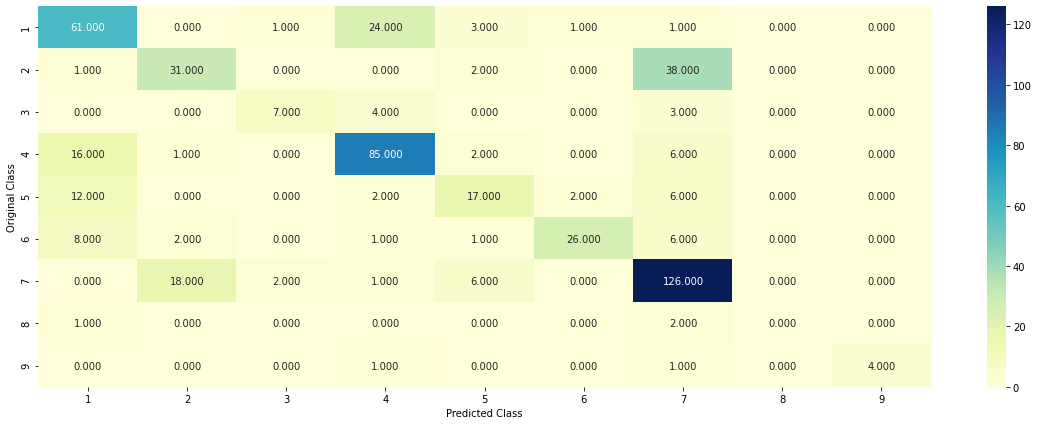

-------------------- Precision matrix (Columm Sum=1) --------------------


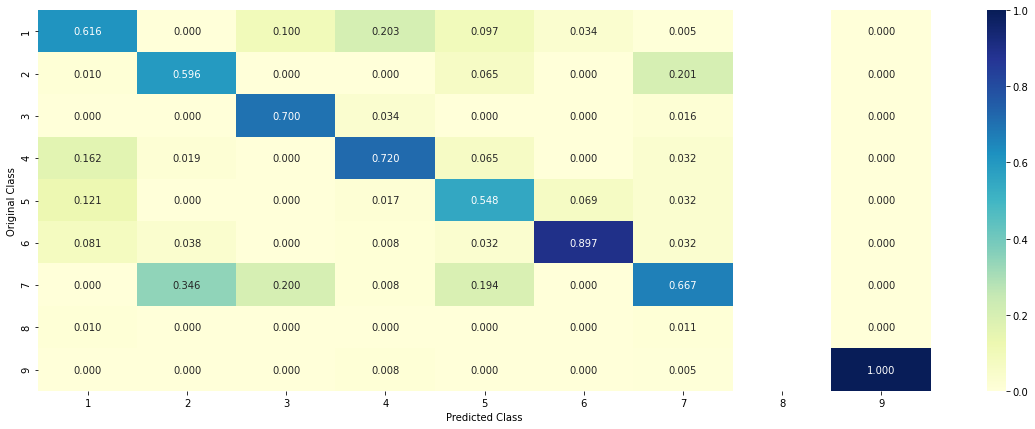

-------------------- Recall matrix (Row sum=1) --------------------


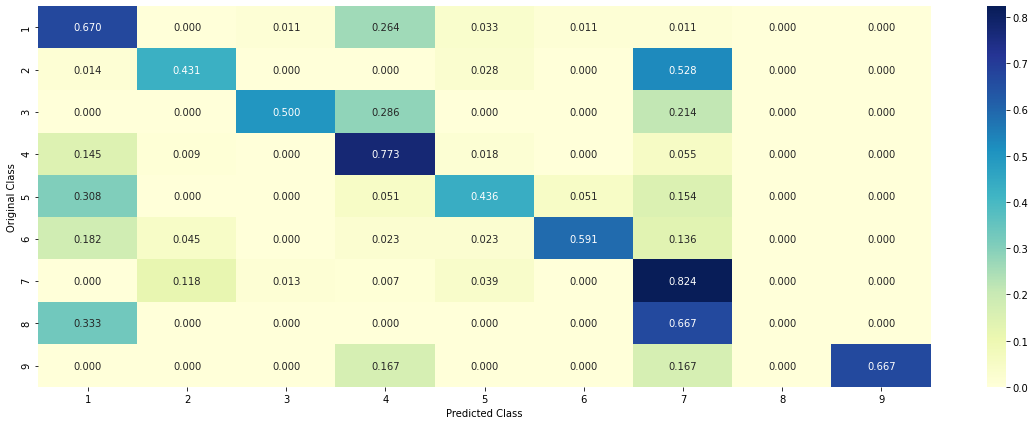

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### WITHOUT CLASS BALANCING

In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3027663619990528
for alpha = 1e-05
Log Loss : 1.2550909414294071
for alpha = 0.0001
Log Loss : 1.1615050759751062
for alpha = 0.001
Log Loss : 1.133304456215054
for alpha = 0.01
Log Loss : 1.2008208838161227
for alpha = 0.1
Log Loss : 1.3758945049641789
for alpha = 1
Log Loss : 1.6238718183360217


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5219539640873629
For values of best alpha =  0.001 The cross validation log loss is: 1.133304456215054
For values of best alpha =  0.001 The test log loss is: 1.1579545683614623


Log loss : 1.133304456215054
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


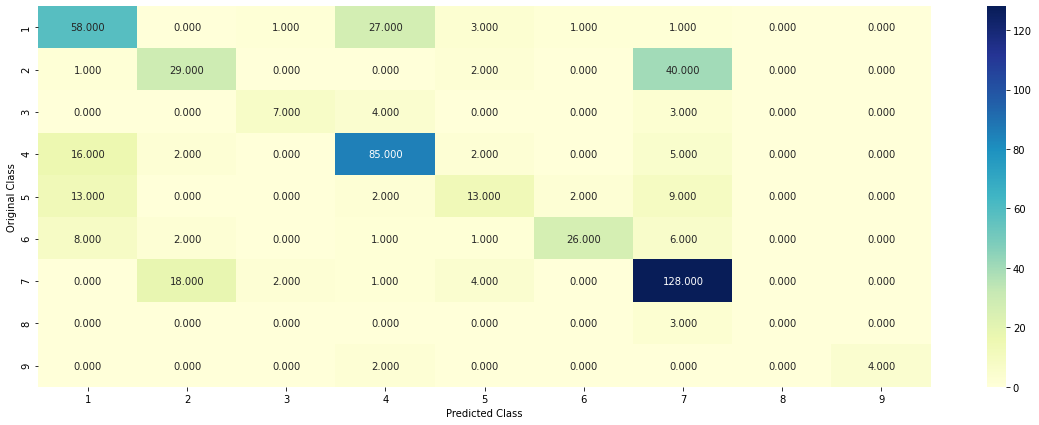

-------------------- Precision matrix (Columm Sum=1) --------------------


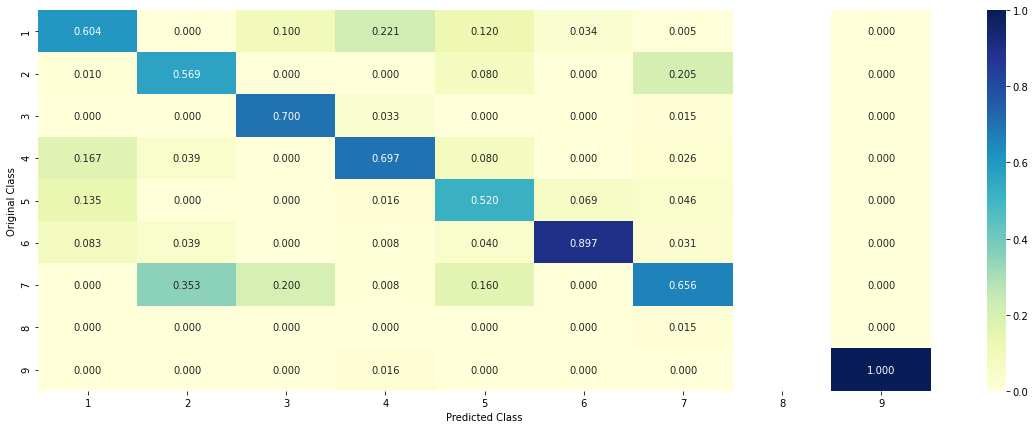

-------------------- Recall matrix (Row sum=1) --------------------


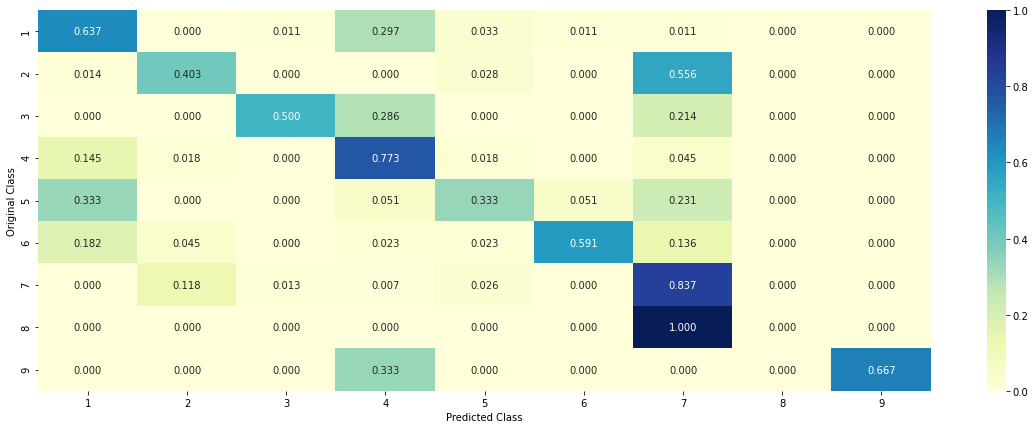

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## LINEAR SVM

In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.2828685930238208
for C = 0.0001
Log Loss : 1.2352666486931139
for C = 0.001
Log Loss : 1.148198041465487
for C = 0.01
Log Loss : 1.1253324731825485
for C = 0.1
Log Loss : 1.357709737764645
for C = 1
Log Loss : 1.6750368371468791
for C = 10
Log Loss : 1.689094690746387
for C = 100
Log Loss : 1.6890894389983826
For values of best alpha =  0.01 The train log loss is: 0.7390684853804821
For values of best alpha =  0.01 The cross validation log loss is: 1.1253324731825485
For values of best alpha =  0.01 The test log loss is: 1.202471843296238


Log loss : 1.1253324731825485
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


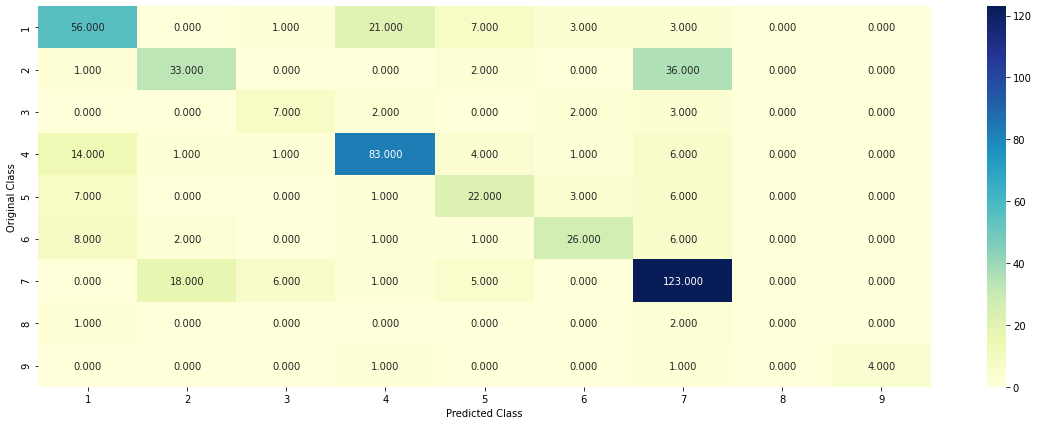

-------------------- Precision matrix (Columm Sum=1) --------------------


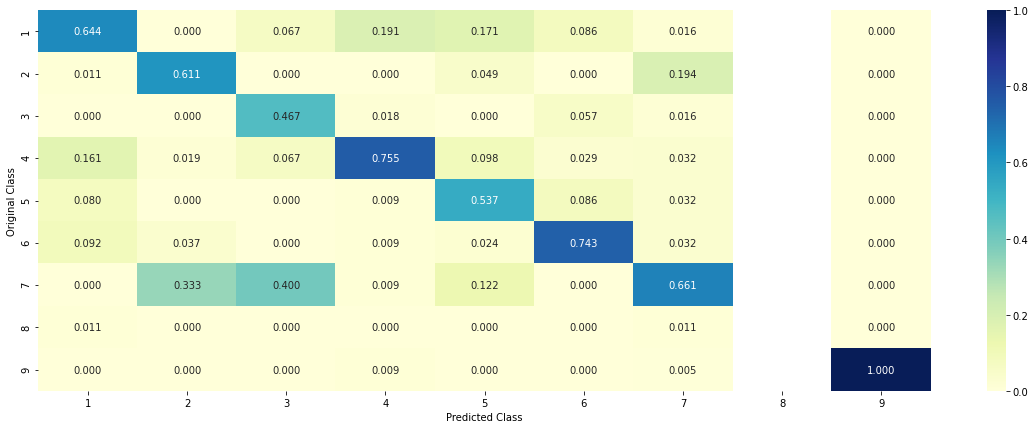

-------------------- Recall matrix (Row sum=1) --------------------


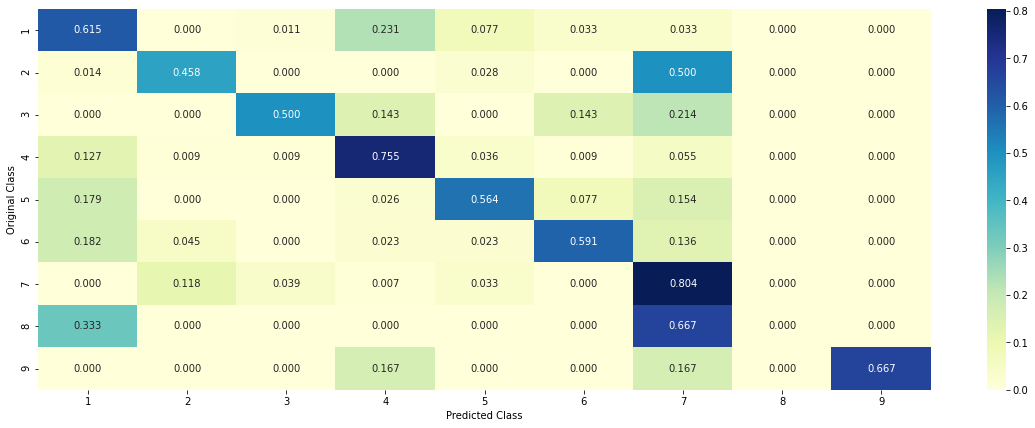

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## ENSEMBLE: STACKING

In [ ]:
# Logistic regression
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

# SVM
clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

# Naive Bayes
clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.68
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.726
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.334
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.163
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.450
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.813


Log loss (train) on the stacking classifier : 0.4861900787414725
Log loss (CV) on the stacking classifier : 1.1632062453157168
Log loss (test) on the stacking classifier : 1.2369008893895754
Number of missclassified point : 0.38345864661654133
-------------------- Confusion matrix --------------------


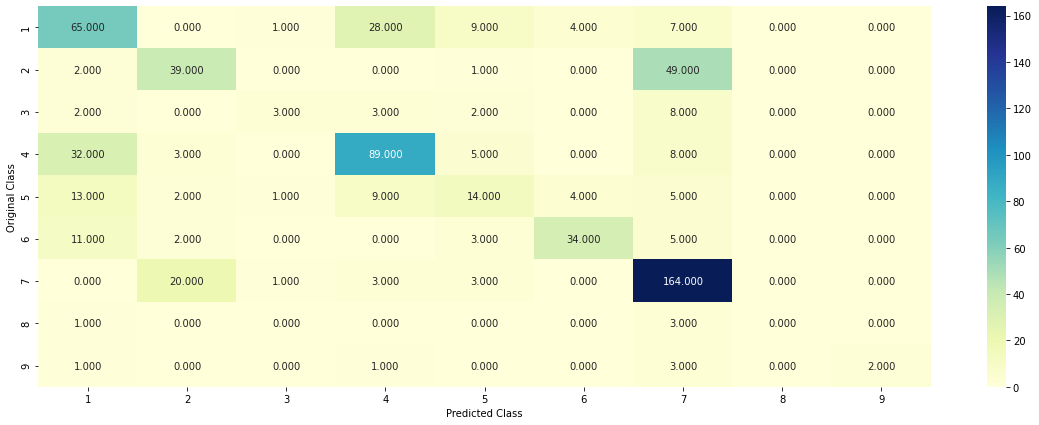

-------------------- Precision matrix (Columm Sum=1) --------------------


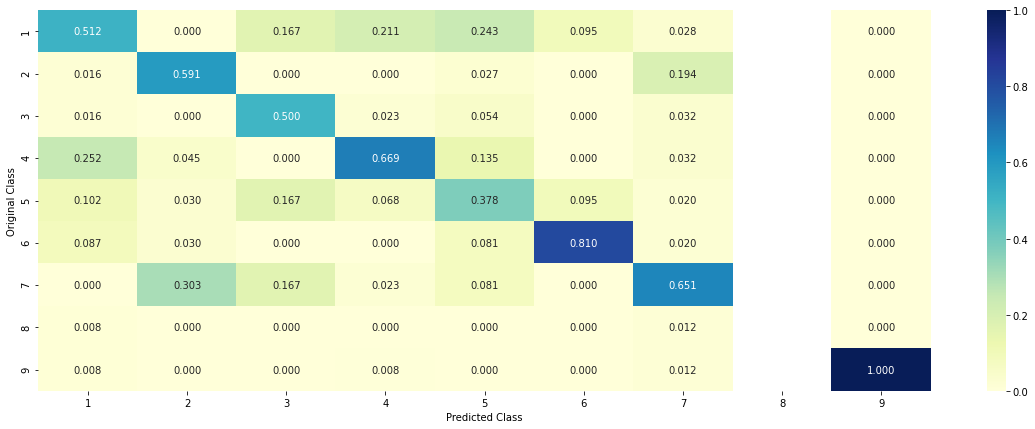

-------------------- Recall matrix (Row sum=1) --------------------


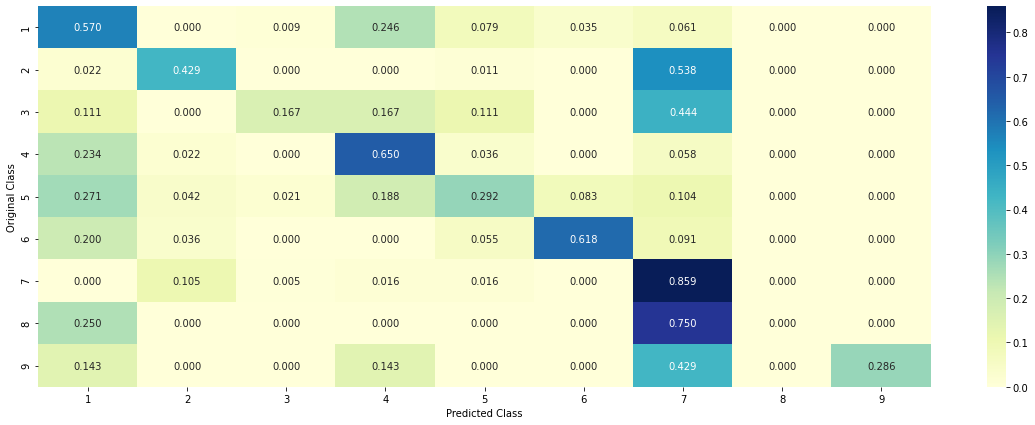

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## MAXIMUM VOTING CLASSIFIER

Log loss (train) on the VotingClassifier : 0.8679358465852208
Log loss (CV) on the VotingClassifier : 1.1767288981258832
Log loss (test) on the VotingClassifier : 1.2248570110254975
Number of missclassified point : 0.3879699248120301
-------------------- Confusion matrix --------------------


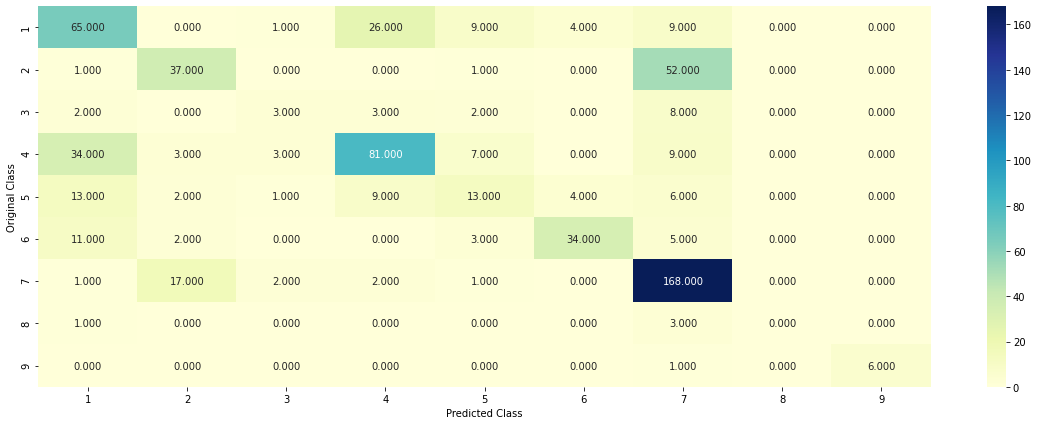

-------------------- Precision matrix (Columm Sum=1) --------------------


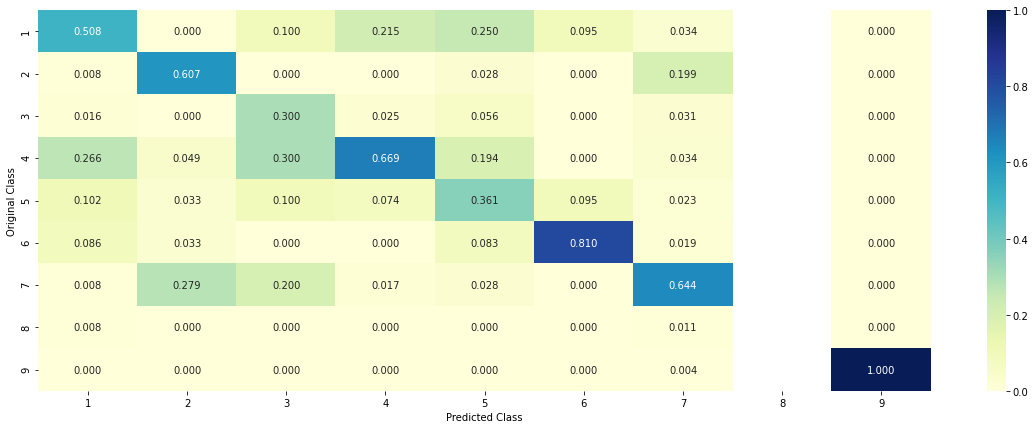

-------------------- Recall matrix (Row sum=1) --------------------


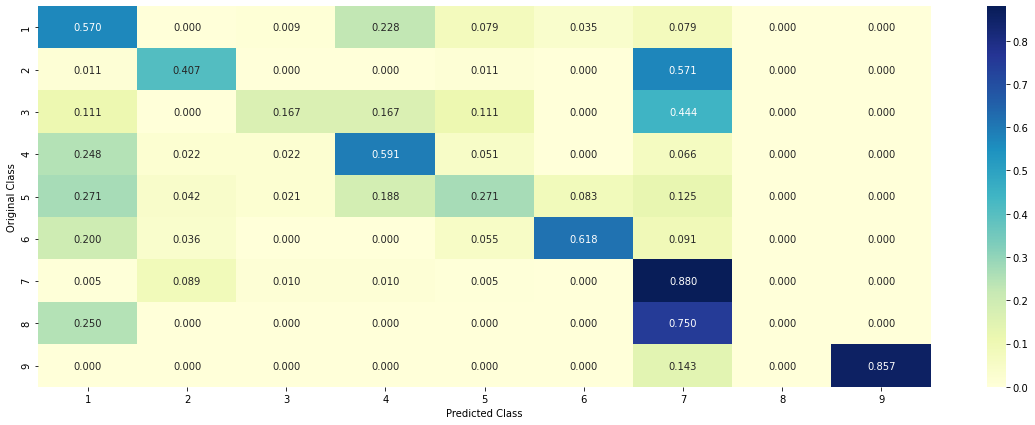

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))